In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim

# Hyperparameters
batch_size = 64
learning_rate = 1e-3
epochs = 20

# Data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Deep Linear Model
class DeepLinear(nn.Module):
    def __init__(self):
        super(DeepLinear, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.layers(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLinear().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for layer in model.layers:
    if isinstance(layer, nn.Linear):
        with torch.no_grad():
            layer.weight.data = torch.where(
                torch.rand_like(layer.weight) > 0.1,
                torch.ones_like(layer.weight),
                -torch.ones_like(layer.weight)
            )
            if layer.bias is not None:
                layer.bias.data.zero_()
        layer.weight.data = torch.where(
            torch.rand_like(layer.weight) > 0.1,
            torch.ones_like(layer.weight),
            -torch.ones_like(layer.weight)
        )
        if layer.bias is not None:
            layer.bias.data.zero_()


# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch [1/20], Loss: 1253533.4977
Epoch [2/20], Loss: 48420.0242
Epoch [3/20], Loss: 30047.8118
Epoch [4/20], Loss: 17733.2357
Epoch [5/20], Loss: 14196.3574
Epoch [6/20], Loss: 6881.7936
Epoch [7/20], Loss: 4016.2883
Epoch [8/20], Loss: 1976.7660
Epoch [9/20], Loss: 1105.2169
Epoch [10/20], Loss: 475.6397
Epoch [11/20], Loss: 344.1635
Epoch [12/20], Loss: 156.7885
Epoch [13/20], Loss: 79.2560
Epoch [14/20], Loss: 46.5776
Epoch [15/20], Loss: 4.7783
Epoch [16/20], Loss: 2.6498
Epoch [17/20], Loss: 2.6425
Epoch [18/20], Loss: 4.4158
Epoch [19/20], Loss: 88.7120
Epoch [20/20], Loss: 12.1476
Test Accuracy: 11.74%


In [2]:
import numpy as np

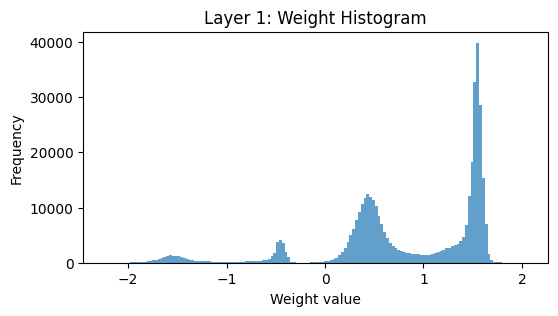

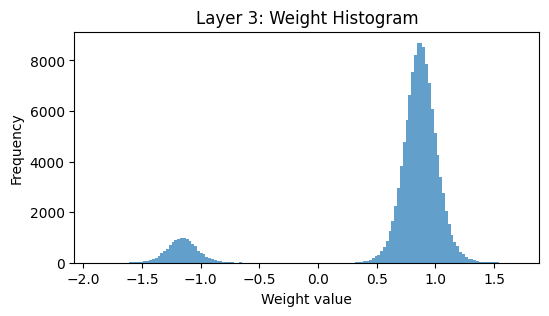

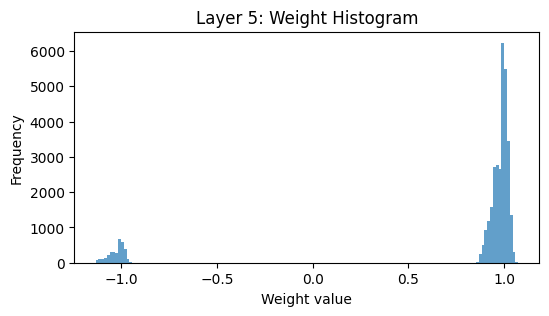

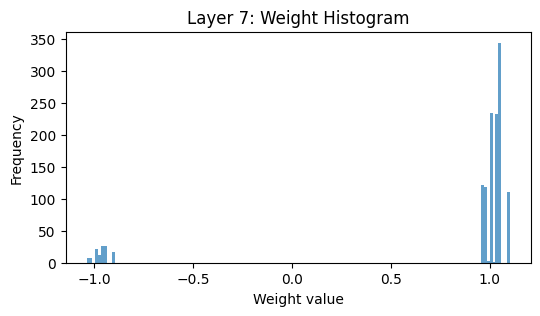

In [3]:
import matplotlib.pyplot as plt

for i, layer in enumerate(model.layers):
    if isinstance(layer, nn.Linear):
        weights = layer.weight.data.cpu().numpy().flatten()
        plt.figure(figsize=(6, 3))
        plt.hist(weights, bins=150, alpha=0.7)
        plt.title(f'Layer {i}: Weight Histogram')
        plt.xlabel('Weight value')
        plt.ylabel('Frequency')
        plt.show()

In [4]:
# class DeepLinear(nn.Module):
#     def __init__(self):
#         super(DeepLinear, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(28*28, 20),
#             nn.ReLU(),
#             nn.Linear(20, 10)
#         )
#     def forward(self, x):
#         return self.layers(x)
    

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = DeepLinear().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# # Evaluation
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# print(f"Test Accuracy: {100 * correct / total:.2f}%")

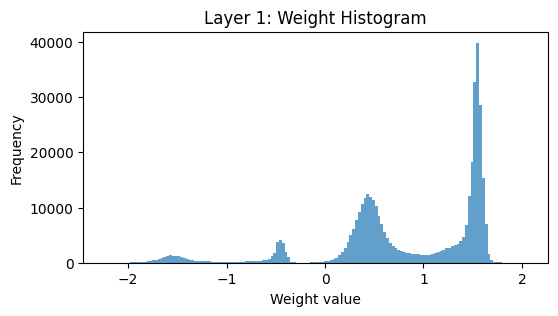

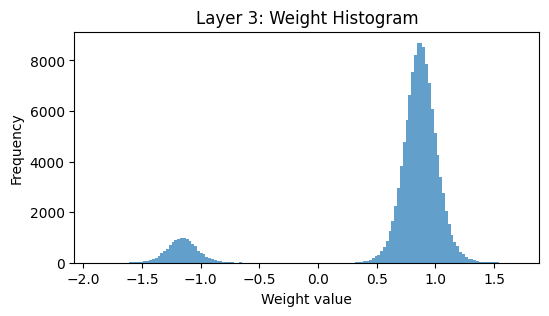

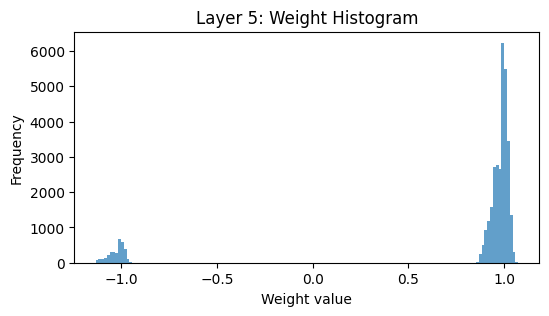

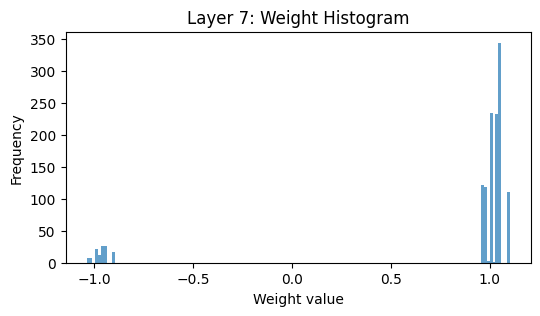

In [5]:
import matplotlib.pyplot as plt

for i, layer in enumerate(model.layers):
    if isinstance(layer, nn.Linear):
        weights = layer.weight.data.cpu().numpy().flatten()
        plt.figure(figsize=(6, 3))
        plt.hist(weights, bins=150, alpha=0.7)
        plt.title(f'Layer {i}: Weight Histogram')
        plt.xlabel('Weight value')
        plt.ylabel('Frequency')
        plt.show()

In [6]:
# Prune weights and count how many are set to zero
num_zeroed = 0
total_params = 0
with torch.no_grad():
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            mask = (layer.weight.abs() <= 0.1)
            num_zeroed += mask.sum().item()
            total_params += mask.numel()
            layer.weight[mask] = 0.0

percent_zeroed = 100 * num_zeroed / total_params if total_params > 0 else 0
print(f"Parameters set to zero: {num_zeroed} / {total_params} ({percent_zeroed:.2f}%)")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy after pruning: {100 * correct / total:.2f}%")

Parameters set to zero: 2040 / 566528 (0.36%)
Test Accuracy after pruning: 11.74%


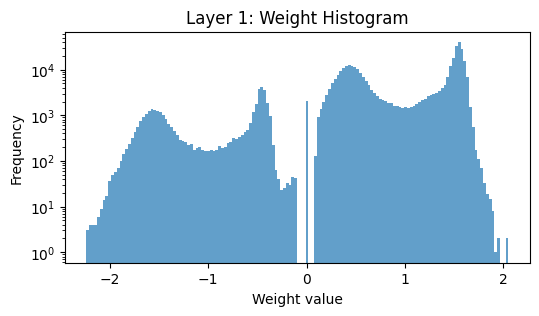

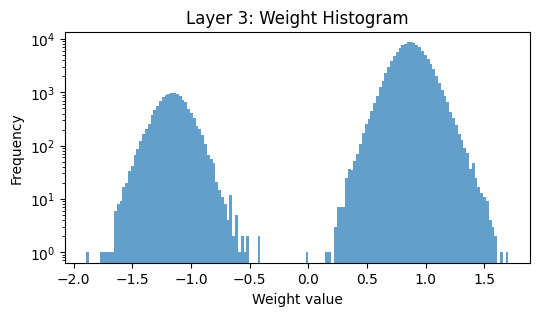

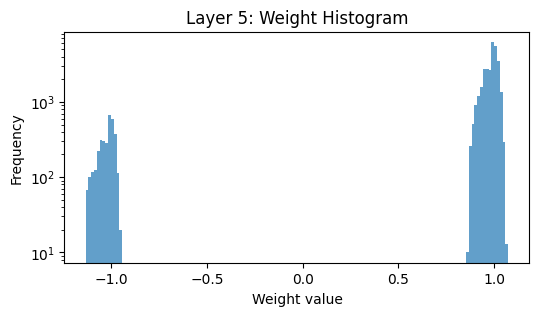

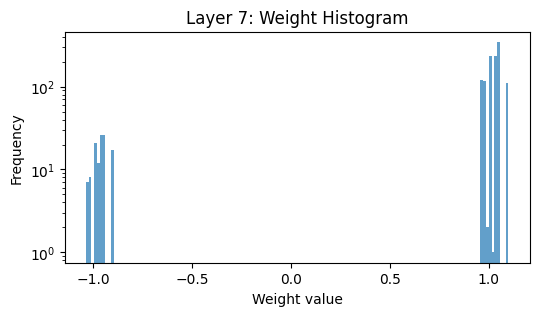

In [7]:
import matplotlib.pyplot as plt

for i, layer in enumerate(model.layers):
    if isinstance(layer, nn.Linear):
        weights = layer.weight.data.cpu().numpy().flatten()
        plt.figure(figsize=(6, 3))
        plt.hist(weights, bins=150, alpha=0.7)
        plt.title(f'Layer {i}: Weight Histogram')
        plt.xlabel('Weight value')
        plt.ylabel('Frequency')
        plt.yscale('log')
        plt.show()
        

In [8]:
# Freeze zero weights in all Linear layers
for layer in model.layers:
    if isinstance(layer, nn.Linear):
        with torch.no_grad():
            zero_mask = (layer.weight == 0)
        layer.weight.register_hook(lambda grad, mask=zero_mask: grad.masked_fill(mask, 0))

# Train for one more epoch with zero weights frozen
model.train()
total_loss = 0
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
avg_loss = total_loss / len(train_loader)
print(f"Retrain Epoch, Loss: {avg_loss:.4f}")

# Evaluate after retraining
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy after retraining: {100 * correct / total:.2f}%")

Retrain Epoch, Loss: 2.4565
Test Accuracy after retraining: 11.73%


Layer 1: Unfreezed parameter count = 400086


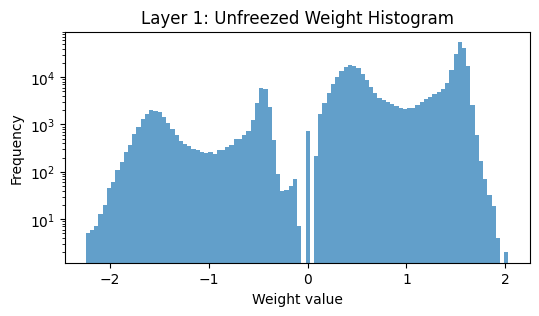

Layer 3: Unfreezed parameter count = 131072


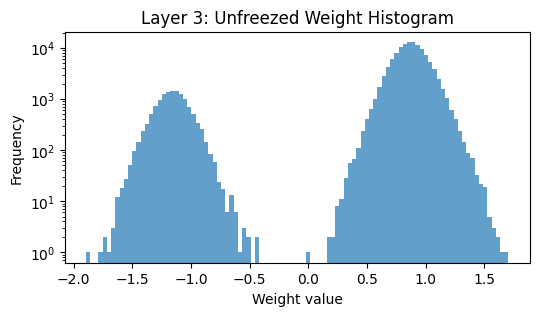

Layer 5: Unfreezed parameter count = 32768


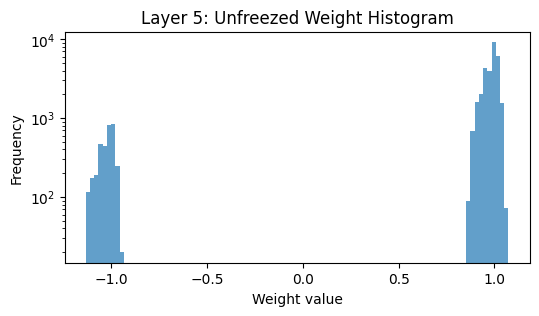

Layer 7: Unfreezed parameter count = 1280


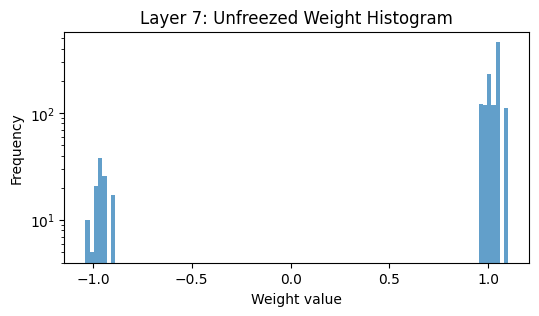

In [9]:
for i, layer in enumerate(model.layers):
    if isinstance(layer, nn.Linear):
        weights = layer.weight.data.cpu().numpy().flatten()
        unfreezed_weights = weights[weights != 0]
        print(f"Layer {i}: Unfreezed parameter count = {unfreezed_weights.size}")
        plt.figure(figsize=(6, 3))
        plt.hist(unfreezed_weights, bins=100, alpha=0.7)
        plt.title(f'Layer {i}: Unfreezed Weight Histogram')
        plt.xlabel('Weight value')
        plt.ylabel('Frequency')
        plt.yscale('log')
        plt.show()

In [10]:
def slim_linear_layer(layer):
    # Find output neurons (rows) where all weights are zero
    weight = layer.weight.data.cpu().numpy()
    bias = layer.bias.data.cpu().numpy() if layer.bias is not None else None
    nonzero_rows = ~(np.all(weight == 0, axis=1))
    # If all neurons are pruned, keep at least one to avoid empty layer
    if not np.any(nonzero_rows):
        nonzero_rows[0] = True
    new_out = np.sum(nonzero_rows)
    new_in = weight.shape[1]
    # Create new Linear layer
    new_layer = nn.Linear(new_in, new_out, bias=(bias is not None)).to(device)
    new_layer.weight.data = torch.from_numpy(weight[nonzero_rows]).to(device)
    if bias is not None:
        new_layer.bias.data = torch.from_numpy(bias[nonzero_rows]).to(device)
    return new_layer, nonzero_rows

# Example: Slim the last Linear layer in your model
old_layer = model.layers[3]
new_layer, kept_outputs = slim_linear_layer(old_layer)
print(f"Original out_features: {old_layer.out_features}, Slimmed out_features: {new_layer.out_features}")

Original out_features: 256, Slimmed out_features: 256
